## 0. Importing relevant data

In [1]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip


## 1. Loading Data set (cars and non-cars)

In [2]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

print(cars[0])
print(notcars[0])

vehicles\GTI_Far\image0000.png
non-vehicles\Extras\extra1.png


## 2. Feature extraction (Histogram of oriented gradients)

The next cell contains some helper code from the course videos

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, visualize=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            #print(np.amax(feature_image))
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                if visualize == True:
                    hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)

                    fig = plt.figure()
                    plt.subplot(121)
                    plt.imshow(image)
                    plt.title('Image')
                    plt.subplot(122)
                    plt.imshow(hog_image)
                    plt.title('HOG')

                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=visualize, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Here I configure the parameters for the HOG descriptor.
I use the RGB color space, 9 orientations and 8x8 cellls with 2 cells per block. I have experimented with multiple orientations and different sizes for the cells however the settings bellow offered best results results. 

In [4]:
sample_car = [cars[1]]
sample_notcar = [notcars[1]]

# Plot HOG visualisation
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 700] # Min and max in y to search in slide_window()


car_features = extract_features(sample_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, visualize=True)


Bellow we display the Hog image and the original image

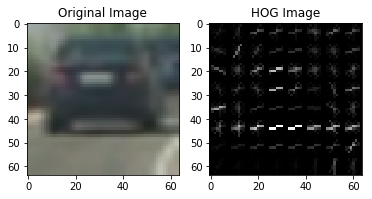

In [5]:
hog_test_img = mpimg.imread(sample_car[0])
hog_test_gray = cv2.cvtColor(hog_test_img, cv2.COLOR_RGB2GRAY)
features, hog_test_result = get_hog_features(hog_test_gray, orient, pix_per_cell, cell_per_block, vis=True)


fig = plt.figure()
plt.subplot(121)
plt.imshow(hog_test_img)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(hog_test_result, cmap='gray')
plt.title('HOG Image')

In the cell bellow we are extracting the features for cars and non-cars. I use only HOG features in order to obtain a higher running time. 


In [6]:
t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, visualize=False)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, visualize=False)
t2 = time.time()
print(round(t2-t, 2), 'Time necessary to extract features')

100.65 Time necessary to extract features


In [7]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 10800


## 3.Training a classifier ( SVM )
We are using suport vector machines in order to perform the daa classification(as sugested in the course).

In [8]:
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
n_samples_predict = 20
t_start = time.time()
print('Predictions: ', svc.predict(X_test[0:n_samples_predict]))
print( 'Labels: ', y_test[0:n_samples_predict])
t_stop = time.time()
print(round(t_stop - t_start, 5), 'Seconds to predict', n_samples_predict,'labels with SVC')

Test Accuracy of SVC =  0.9651
Predictions:  [ 0.  1.  1.  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.
  1.  0.]
Labels:  [ 0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.
  1.  0.]
0.03803 Seconds to predict 20 labels with SVC


A way in which we could improve the data classification would be to use other features together with HOG, like histogram features, Local Binary Patterns, Histogram of Laplacian of Gaussian, good features to track etc. Another method to improve the results would be to use an ansemble classifier (a strong classifier which would be made by multiple week classifiers - like ada boost).

# 4. Sliding window approach
The code is based on the samples offered in the course.
Based on an initial set of coordinates, we compute and store in an array a number of windows in multiple directions. The data will have the following structure: start x, start y ; end x, end y;

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

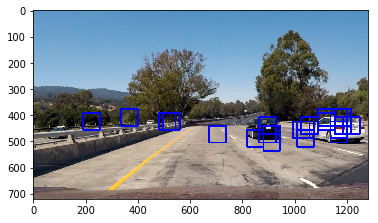

In [10]:
image = mpimg.imread('test_images/test1.jpg').astype(np.float32)/255
plt.imshow(image)
draw_image = np.copy(image)

y_start_stop = [int(image.shape[0]*0.5), int(image.shape[0]*0.85)]

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))

filtered_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, filtered_windows, color=(0, 0, 1), thick=6)                    

plt.imshow(window_img)

Here I generate scan boxes where. The boxes were generated as it was suggested in the course. 
I "split" my image in 3 regions(near, middle and far) and generate scan boxes of different sizes. The sky region
was filtered out so I don't search for vehicles in that region. I applyed the generate scan boxes
function twice with different parameters in order to have more scan boxes.

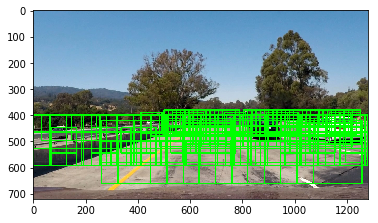

In [11]:
def generate_scan_boxes(image, far = 10, mid = 5, near = 3,
                        far_xssx=[None, None] ,far_xssy =[None, None], fxy_window=(100,100),fxy_overlap=(0.5,0.5),
                        mid_xssx=[None, None] ,mid_xssy =[None, None], mxy_window=(100,100), mxy_overlap=(0.5,0.5),
                        near_xssx=[None, None] ,near_xssy =[None, None], nxy_window=(100,100), nxy_overlap=(0.5,0.5)):
    #Create a list to append scan window coordinates
    scan_windows = []
    far_windows = slide_window(image, x_start_stop=far_xssx, y_start_stop=far_xssy, \
                         xy_window=fxy_window, xy_overlap=fxy_overlap)
    for i in range (far):
        f = np.random.randint(0, len(far_windows))
        scan_windows.append(far_windows[f])
       
    middle_windows = slide_window(image, x_start_stop=mid_xssx, y_start_stop=mid_xssy, \
                         xy_window=mxy_window, xy_overlap=mxy_overlap)
    for i in range (mid):
        m = np.random.randint(0, len(middle_windows))
        scan_windows.append(middle_windows[m])
    
    near_windows = slide_window(image, x_start_stop=near_xssx, y_start_stop=near_xssy, \
                          xy_window=nxy_window, xy_overlap=nxy_overlap)
    for i in range (near):
        n = np.random.randint(0, len(near_windows))
        scan_windows.append(near_windows[n])

    return scan_windows

image = mpimg.imread('test_images/test1.jpg').astype(np.float32)/255 
boxes = generate_scan_boxes(image, far = 80, mid = 60, near = 30,
                            far_xssx=[500, None], far_xssy=[380, 500],fxy_window=(64,64),fxy_overlap=(0.75,0.5),
                            mid_xssx=[450, None] ,mid_xssy =[400,550], mxy_window=(128,80), mxy_overlap=(0.75,0.5),
                            near_xssx=[200,None] ,near_xssy =[420,700], nxy_window=(250,160), nxy_overlap=(0.75,0.5)
                           )
window_img = draw_boxes(image, boxes, color=(0, 1, 0), thick=4)                    

boxes = generate_scan_boxes(image, far = 70, mid = 50, near = 20,
                            far_xssx=[None, None], far_xssy=[400, 640],fxy_window=(128,128),fxy_overlap=(0.5,0.5),
                            mid_xssx=[32, None] ,mid_xssy =[400,600], mxy_window=(96,96), mxy_overlap=(0.6,0.5),
                            near_xssx=[412,1280] ,near_xssy =[390,540], nxy_window=(80,80), nxy_overlap=(0.5,0.5)
                           )
window_img = draw_boxes(window_img, boxes, color=(0, 1, 0), thick=4)                    

plt.imshow(window_img)


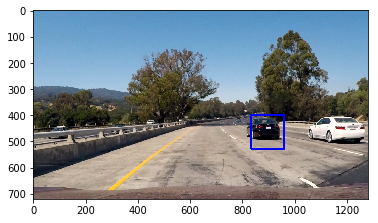

In [12]:
filtered_roi_windows = search_windows(image, boxes, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(image, filtered_roi_windows, color=(0, 0, 1), thick=6)                    

plt.imshow(window_img)

## 5. Heat Map
The heat map code is based on the code provided in the course

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

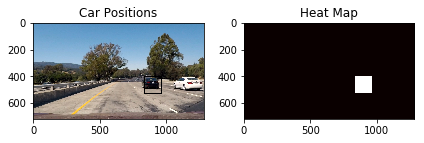

In [14]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

box_list = filtered_roi_windows
# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

##  6. Image Processing Pieline
Bellow the pipeline for processing one image is presented.

In [15]:
def process_image(img):  
    image = img
     
   # y_start_stop = [int(image.shape[0]*0.4), int(image.shape[0]*0.9)]

    boxes1 = generate_scan_boxes(image, far = 80, mid = 60, near = 30,
                            far_xssx=[500, None], far_xssy=[380, 500],fxy_window=(64,64),fxy_overlap=(0.75,0.5),
                            mid_xssx=[450, None] ,mid_xssy =[400,550], mxy_window=(128,80), mxy_overlap=(0.75,0.5),
                            near_xssx=[200,None] ,near_xssy =[420,700], nxy_window=(250,160), nxy_overlap=(0.75,0.5)
                           )

    boxes2 = generate_scan_boxes(image, far = 70, mid = 50, near = 20,
                            far_xssx=[None, None], far_xssy=[400, 640],fxy_window=(128,128),fxy_overlap=(0.5,0.5),
                            mid_xssx=[32, None] ,mid_xssy =[400,600], mxy_window=(96,96), mxy_overlap=(0.6,0.5),
                            near_xssx=[412,1280] ,near_xssy =[390,540], nxy_window=(80,80), nxy_overlap=(0.5,0.5)
                           )
    boxes = boxes1 + boxes2
    find_car_img = []
    find_car_boxes = []
    
    for box in boxes:
        x1, y1, x2, y2 = box[0][0], box[0][1], box[1][0], box[1][1]
    
        crop = image[y1:y2, x1:x2]  
        resize_img = cv2.resize(crop, (64, 64))

        test_feature = single_img_features(resize_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        scaled_test = X_scaler.transform(test_feature)

        if svc.predict(scaled_test) == 1:
               if abs(x1 - x2) * abs(y1 - y2) > 100:
                    find_car_img.append(crop)
                    find_car_boxes.append(box)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,find_car_boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # from scipy.ndimage.measurements import label
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_labeled_bboxes(img, labels)
    
    
    return draw_img


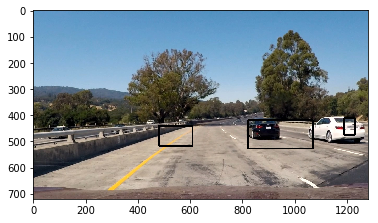

In [16]:
image = mpimg.imread('test_images/test1.jpg').astype(np.float32)/255
res = process_image(image)
plt.imshow(res)

## 7. Process video
I process a sequence of video frames. I create a queue for storing the hot boxes from a set of frames

In [17]:
class BoxesQueue():
    """Queue for storing hot boxes from last 10 frames
    """
    def __init__(self):
        self.queue_max = 10 # queue size
        self.last_boxes = []

    def put_hot_boxes(self, boxes):
        """Store boxes
        """
        if (len(self.last_boxes) > self.queue_max):
            tmp = self.last_boxes.pop(0)
        
        self.last_boxes.append(boxes)
        
    def get_hot_boxes(self):
        """Get boxes
        """
        b = []
        for boxes in self.last_boxes:
            b.extend(boxes)
        return b

last_hot_boxes = BoxesQueue()


def process_video(img):
    image = img
     
    y_start_stop = [int(image.shape[0]*0.4), int(image.shape[0]*0.9)]

    boxes1 = generate_scan_boxes(image, far = 80, mid = 60, near = 30,
                            far_xssx=[500, None], far_xssy=[380, 500],fxy_window=(64,64),fxy_overlap=(0.75,0.5),
                            mid_xssx=[450, None] ,mid_xssy =[400,550], mxy_window=(128,80), mxy_overlap=(0.75,0.5),
                            near_xssx=[200,None] ,near_xssy =[420,700], nxy_window=(250,160), nxy_overlap=(0.75,0.5)
                           )

    boxes2 = generate_scan_boxes(image, far = 80, mid = 60, near = 30,
                            far_xssx=[None, None], far_xssy=[400, 640],fxy_window=(128,128),fxy_overlap=(0.5,0.5),
                            mid_xssx=[32, None] ,mid_xssy =[400,600], mxy_window=(96,96), mxy_overlap=(0.6,0.5),
                            near_xssx=[412,1280] ,near_xssy =[390,540], nxy_window=(80,80), nxy_overlap=(0.5,0.5)
                           )
    boxes = boxes1 + boxes2
    find_car_img = []
    find_car_boxes = []
    
    for box in boxes:
        x1, y1, x2, y2 = box[0][0], box[0][1], box[1][0], box[1][1]
    
        crop = image[y1:y2, x1:x2]  
        resize_img = cv2.resize(crop, (64, 64))

        test_feature = single_img_features(resize_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        scaled_test = X_scaler.transform(test_feature)

        if svc.predict(scaled_test) == 1:
            if abs(x1 - x2) * abs(y1 - y2) > 100:
                find_car_img.append(crop)
                find_car_boxes.append(box)
    
    # Hot boxes queue
    last_hot_boxes.put_hot_boxes(find_car_boxes)
    find_car_boxes = last_hot_boxes.get_hot_boxes()
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, find_car_boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 45)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_labeled_bboxes(img, labels)  
    
    return draw_img


In [18]:
write_output = './test_video_out.mp4'
clip1 = VideoFileClip('./test_video.mp4')
write_clip = clip1.fl_image(process_video)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video ./test_video_out.mp4
[MoviePy] Writing video ./test_video_out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [01:13<00:01,  1.97s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out.mp4 

Wall time: 1min 14s


In [19]:
write_output = './project_video_out.mp4'
clip1 = VideoFileClip('./project_video.mp4')
write_clip = clip1.fl_image(process_video)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [40:30<00:01,  1.99s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

Wall time: 40min 31s
